# <center> Predicting Customer Response to Telemarketing Campaigns

## Load the raw data

In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os


dataset1 = pd.read_csv('bank-full.csv')

In [2]:
# View the first 5 rows in the dataset
dataset1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Clean the dataset

In [3]:
#Delete the rows which column 'poutcome' contains 'other'
condition = dataset1.poutcome == 'other'
dataset2 = dataset1.drop(dataset1[condition].index, axis = 0, inplace = False)

In [4]:
#Replace 'unknown' in job and education with 'other'
dataset2[['job','education']] = dataset2[['job','education']].replace(['unknown'],'other')

### 2.2 Drop outliers in the column 'balance'

In [5]:
from scipy.stats import zscore

dataset2[['balance']].mean()
dataset2[['balance']].mean()

dataset2['balance_outliers'] = dataset2['balance']
dataset2['balance_outliers']= zscore(dataset2['balance_outliers'])

condition1 = (dataset2['balance_outliers']>3) | (dataset2['balance_outliers']<-3 )
dataset3 = dataset2.drop(dataset2[condition1].index, axis = 0, inplace = False)

In [6]:
dataset4 = dataset3.drop('balance_outliers', axis=1)

### 2.3 Creating and transforming data

In [7]:
# Step 1: Change column name: 'y' to 'response'
dataset4.rename(index=str, columns={'y': 'response'}, inplace = True)

def convert(dataset4, new_column, old_column):
    dataset4[new_column] = dataset4[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return dataset4[new_column].value_counts()

convert(dataset4, "response_binary", "response")

0    37785
1     4870
Name: response_binary, dtype: int64

In [8]:
# Step 2: Drop column "contact" which is useless
dataset5 = dataset4.drop('contact', axis=1)

In [9]:
# Step 3: Change the unit of 'duration' from seconds to minutes
dataset5['duration'] = dataset5['duration'].apply(lambda n:n/60).round(2)

In [10]:
# Step 4: Change 'month' from words to numbers for easier analysis
lst = [dataset5]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

### 2.4 Filtering

In [11]:
# Step 1: Drop rows that 'duration' < 5s
condition2 = (dataset5['duration']<5/60)
dataset6 = dataset5.drop(dataset5[condition2].index, axis = 0, inplace = False)

In [12]:
# Step 2: Drop customer values with 'other' education
condition3 = (dataset6['education'] == 'other')
dataset7 = dataset6.drop(dataset6[condition3].index, axis = 0, inplace = False)

# Part 3. Exploratory Data Analysis <a id="3"></a>

To obtain a better understanding of the dataset, the distribution of key variables and the relationships among them were plotted.

### 3.1 Visualize the distribution of 'age' and 'balance'

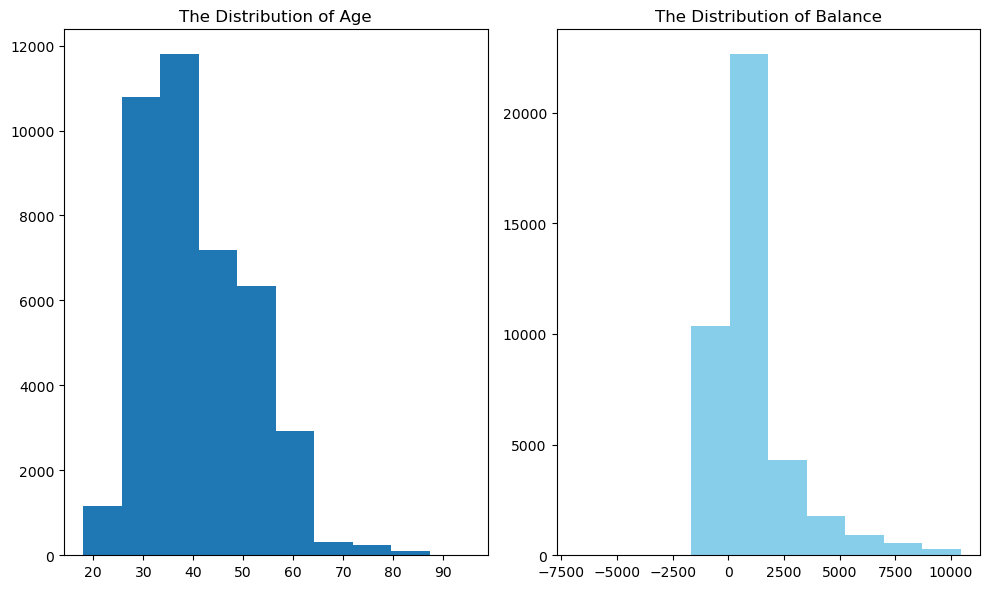

In [13]:
dist_age_balance = plt.figure(figsize = (10,6))

ra1 = dist_age_balance.add_subplot(1,2,1) 
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(dataset7['age'])
ra1.set_title('The Distribution of Age')

ra2.hist(dataset7['balance'], color = 'skyblue')
ra2.set_title('The Distribution of Balance')

plt.tight_layout() 
plt.show()

### 3.2 Visualize the relationship between 'age' and 'balance' 

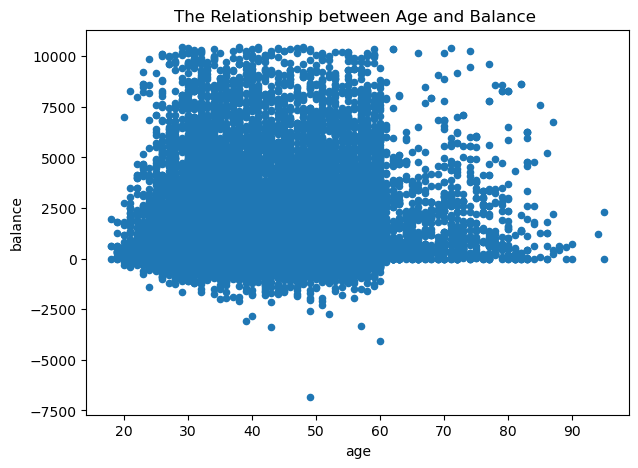

In [14]:
scatter_age_balance = dataset7.plot.scatter('age','balance',figsize = (7,5))

plt.title('The Relationship between Age and Balance ')
plt.show()

### 3.3 Visualize the distribution of 'duration' & 'campaign'

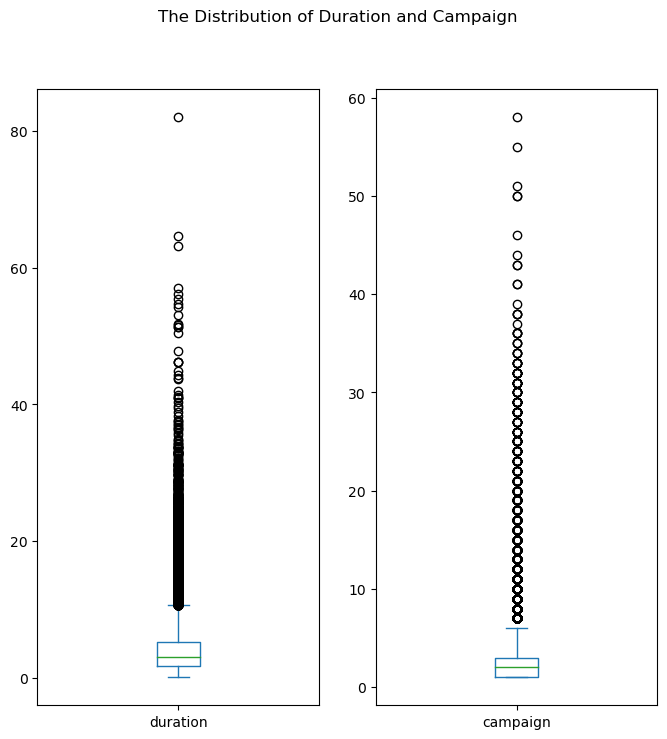

In [15]:
dist_dur_cam = dataset7[['duration','campaign']].plot(kind = 'box', 
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

### 3.4 Visualize the relationship between 'duration' & 'campaign': with response result 

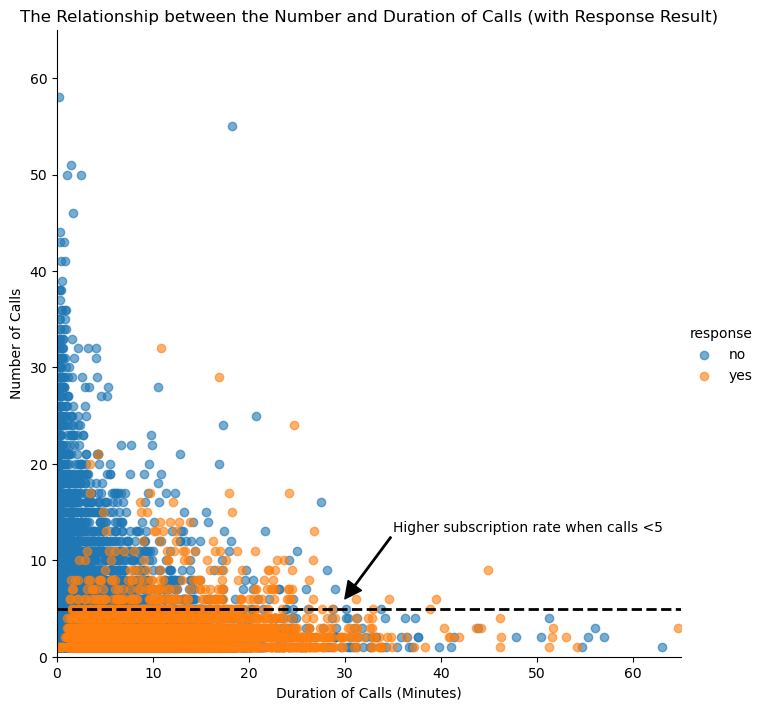

In [16]:
import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = dataset7,
                     hue = 'response',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

### 3.5 Scatter matrix and Correlation matrix

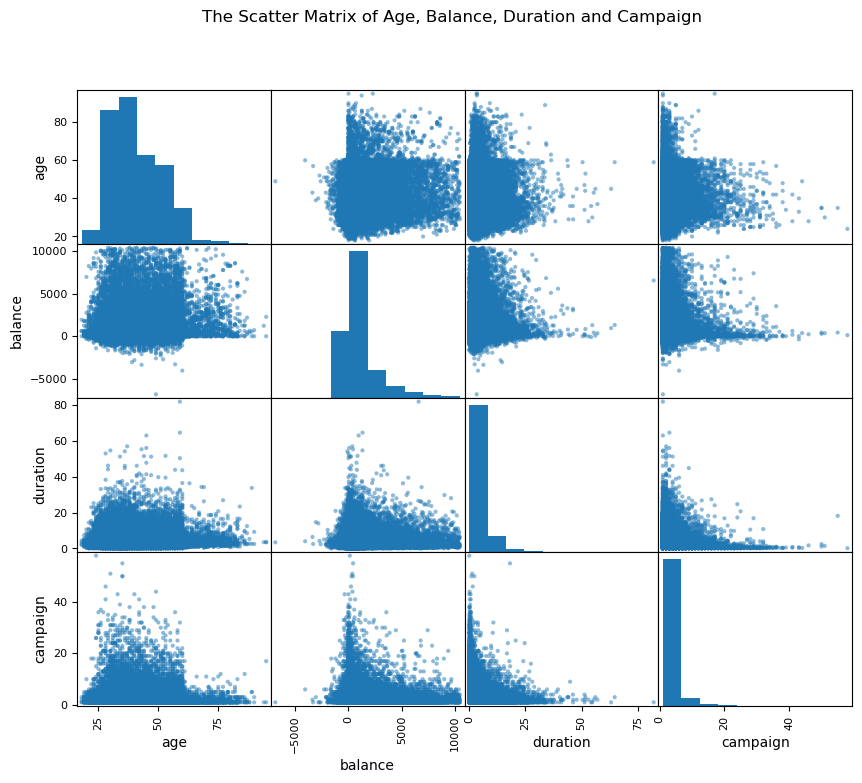

In [17]:
from pandas.plotting import scatter_matrix
matrix = scatter_matrix(dataset7[['age','balance','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

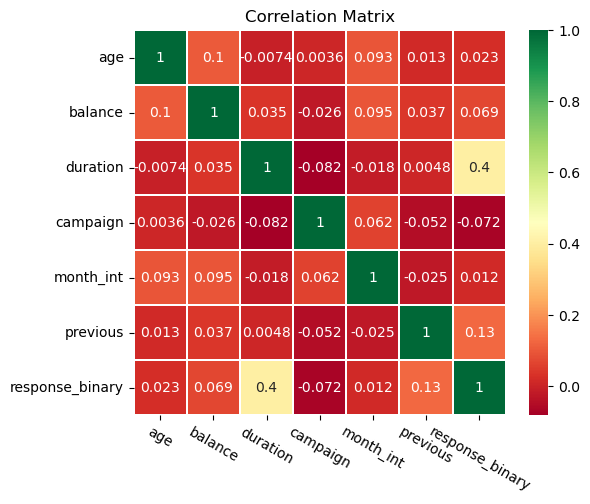

In [18]:
corr_data = dataset7[['age','balance','duration','campaign','month_int','previous','response_binary']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

# Part 4. Data Visualization <a id="4"></a>

### 4.1 Visualize the subscription and contact rate by age

In [19]:
lst = [dataset7]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60
    

In [20]:
lst

[       age           job   marital  education default  balance housing loan  \
 0       58    management   married   tertiary      no     2143     yes   no   
 1       44    technician    single  secondary      no       29     yes   no   
 2       33  entrepreneur   married  secondary      no        2     yes  yes   
 5       35    management   married   tertiary      no      231     yes   no   
 6       28    management    single   tertiary      no      447     yes  yes   
 ...    ...           ...       ...        ...     ...      ...     ...  ...   
 45205   25    technician    single  secondary      no      505      no  yes   
 45206   51    technician   married   tertiary      no      825      no   no   
 45207   71       retired  divorced    primary      no     1729      no   no   
 45208   72       retired   married  secondary      no     5715      no   no   
 45209   57   blue-collar   married  secondary      no      668      no   no   
 
        day month  duration  campaign 

In [21]:
count_age_response_pct = pd.crosstab(dataset7['response'],dataset7['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose() 
count_age_response_pct

response,no,yes
age_group,,
20.0,83.013699,16.986301
30.0,89.635398,10.364602
40.0,91.175912,8.824088
50.0,90.817141,9.182859
60.0,66.599462,33.400538


In [22]:
age = pd.DataFrame(dataset7['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct['yes']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)
age

,% Contacted,% Subscription,age
20.0,11.618227,16.986301,20
30.0,40.562180,10.364602,30
40.0,25.778017,8.824088,40
50.0,18.398178,9.182859,50
60.0,3.643398,33.400538,60


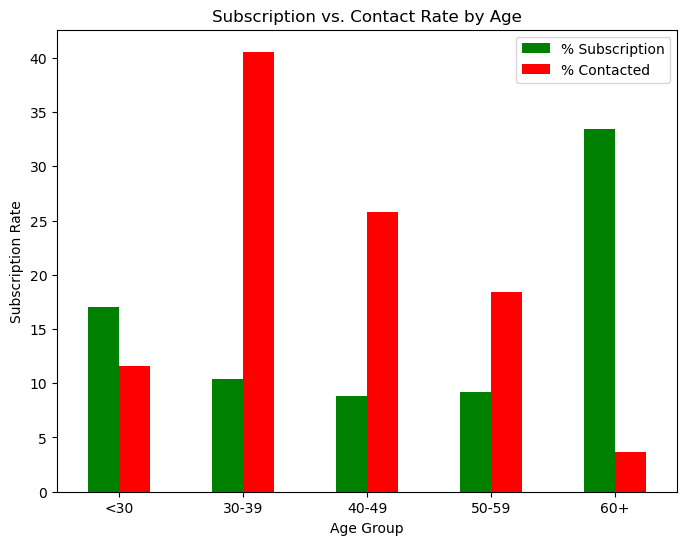

In [23]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

### 4.2 Visualize the subscription rate by balance level

In [24]:
lst = [dataset7]
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000), 'balance_group'] = 'high balance'

In [25]:
lst

[       age           job   marital  education default  balance housing loan  \
 0       58    management   married   tertiary      no     2143     yes   no   
 1       44    technician    single  secondary      no       29     yes   no   
 2       33  entrepreneur   married  secondary      no        2     yes  yes   
 5       35    management   married   tertiary      no      231     yes   no   
 6       28    management    single   tertiary      no      447     yes  yes   
 ...    ...           ...       ...        ...     ...      ...     ...  ...   
 45205   25    technician    single  secondary      no      505      no  yes   
 45206   51    technician   married   tertiary      no      825      no   no   
 45207   71       retired  divorced    primary      no     1729      no   no   
 45208   72       retired   married  secondary      no     5715      no   no   
 45209   57   blue-collar   married  secondary      no      668      no   no   
 
        day month  duration  campaign 

In [26]:
count_balance_response_pct = pd.crosstab(dataset7['response'],dataset7['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()
count_balance_response_pct

response,no,yes
balance_group,,
average balance,85.237209,14.762791
high balance,85.080856,14.919144
low balance,89.265352,10.734648
no balance,93.078512,6.921488


In [27]:
bal = pd.DataFrame(dataset7['balance_group'].value_counts())
bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
bal['% Subscription'] = count_balance_response_pct['yes']
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)

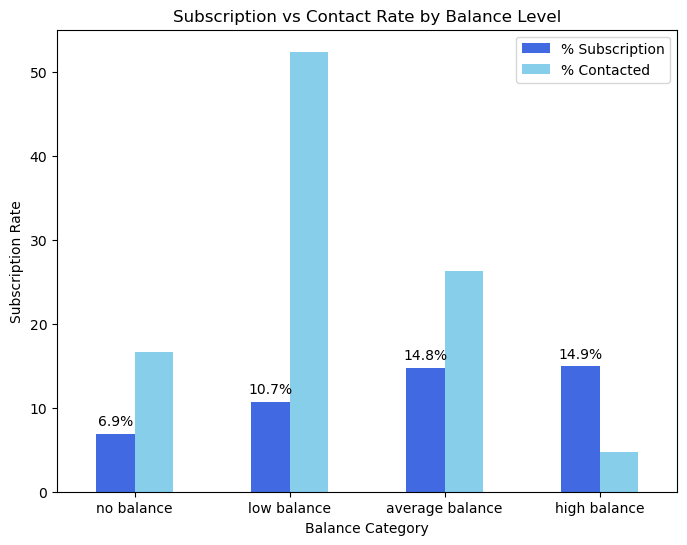

In [28]:
plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('royalblue','skyblue'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

### 4.3 Visualize the subscription rate by age and balance

In [29]:
age_balance1 = pd.DataFrame(dataset7.groupby(['age_group','balance_group'])['response_binary'].sum())
age_balance2 = pd.DataFrame(dataset7.groupby(['age_group','balance_group'])['response'].count())

age_balance1['response'] = age_balance2['response']
age_balance1['response_rate'] = age_balance1['response_binary']/ (age_balance1['response'])
age_balance1 = age_balance1.drop(['response_binary','response'],axis =1)

age_balance1 = age_balance1.unstack()

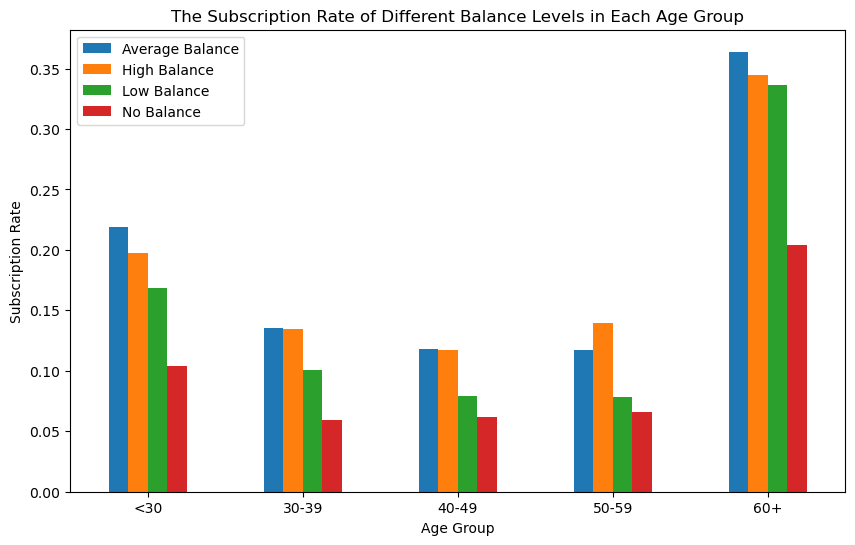

In [30]:
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

### 4.4 Visualize the subscription rate by job

In [31]:
count_job_response_pct = pd.crosstab(dataset7['response'],dataset7['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct = count_job_response_pct.transpose()

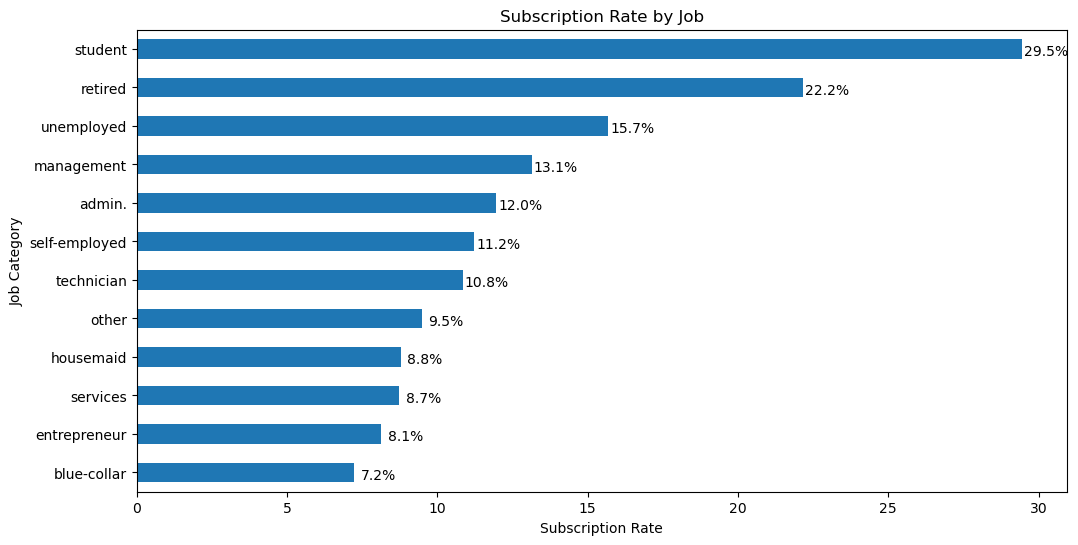

In [32]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

### 4.5 Visualize the subscription and contact rate by month

In [33]:
count_month_response_pct = pd.crosstab(dataset7['response'],dataset7['month_int']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()

In [34]:
month = pd.DataFrame(dataset7['month_int'].value_counts())
month['% Contacted'] = month['month_int']*100/month['month_int'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.drop('month_int',axis = 1,inplace = True)

month['Month'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('Month',ascending = True)

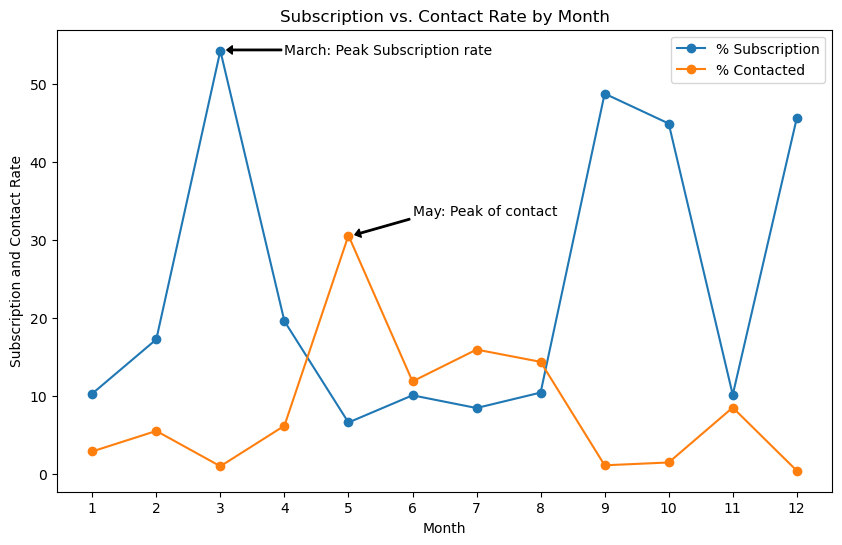

In [35]:
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of contact
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Peak of contact', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of subscription rate
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Peak Subscription rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

# Part 5. Machine Learning: Classification

## Load the cleaned dataset

In [36]:

dataset = pd.read_csv(r"C:\Users\User\kaggle\bank telemarketing\bank_cleaned.csv")
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [37]:
# View the first 5 rows of cleaned data
dataset.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0


## Prepare Data for Classification

### 5.1 Select variables relevant to customers

In [38]:
dataset.drop(['marital'],axis=1, inplace=True)
dataset1 = dataset.iloc[:, 0:7]

In [39]:
dataset1

,age,job,education,default,balance,housing,loan
0,58,management,tertiary,no,2143,yes,no
1,44,technician,secondary,no,29,yes,no
2,33,entrepreneur,secondary,no,2,yes,yes
3,35,management,tertiary,no,231,yes,no
4,28,management,tertiary,no,447,yes,yes
...,...,...,...,...,...,...,...
40836,25,technician,secondary,no,505,no,yes
40837,51,technician,tertiary,no,825,no,no
40838,71,retired,primary,no,1729,no,no
40839,72,retired,secondary,no,5715,no,no


### 5.2 Tranform categorical data into dummy variables

In [40]:
dataset2 = pd.get_dummies(dataset1, columns = ['job'])
dataset2 = pd.get_dummies(dataset2, columns = ['education'])
dataset2['housing'] = dataset2['housing'].map({'yes': 1, 'no': 0})
dataset2['default'] = dataset2['default'].map({'yes': 1, 'no': 0})
dataset2['loan'] = dataset2['loan'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(dataset['response_binary'])
dataset2 = pd.merge(dataset2, dataset_response, left_index = True, right_index = True)

### 5.3 Feature selection

In [41]:
array = dataset2.values

# Features: first 20 columns
X = array[:,0:-1]

# Target variable: 'response_binary'
Y = array[:,-1]

### 5.4 Train/ test split

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [43]:
# 20% of the data will be used for testing
test_size= 0.20
seed = 7
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

## Compare classification algorithms

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [45]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(("MLP",MLPClassifier()))
models.append(("RFC", RandomForestClassifier()))
models.append(("SVM", svm.SVC()))

In [46]:
results_c = []
names_c = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    kfold = KFold(n_splits=10, random_state=seed , shuffle=True)    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')    
    results_c.append(cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.885284 (0.004086)
KNN: 0.875520 (0.004255)
CART: 0.830252 (0.004951)
NB: 0.823886 (0.006957)
MLP: 0.875030 (0.022209)
RFC: 0.874051 (0.005466)
SVM: 0.885284 (0.004086)


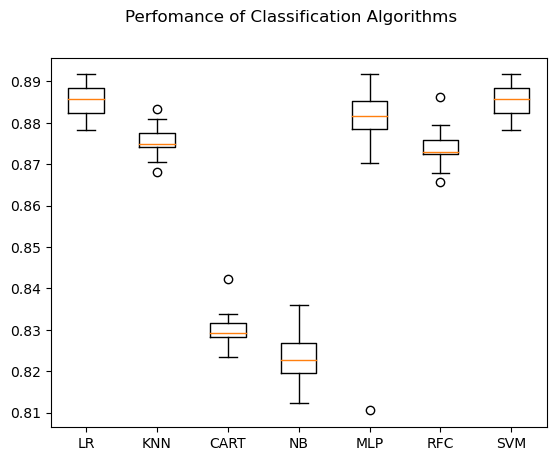

In [47]:
fig = plt.figure()
fig.suptitle('Perfomance of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results_c)
ax.set_xticklabels(names_c)
plt.show()

## Test models on the test set

In [48]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

LogisticRegression()

In [49]:
KNN = KNeighborsClassifier()
CART = DecisionTreeClassifier()
NB = GaussianNB()
MLP = MLPClassifier()
RFC = RandomForestClassifier()
SVM = svm.SVC()
modelToFit=[LR,KNN,CART,NB,MLP,RFC,SVM]
for model in modelToFit :
    model.fit(X_train , Y_train)


## Evalute Models

In [50]:
predictionsLR = LR.predict(X_test)

In [51]:
predictionsKNN = KNN.predict(X_test)
predictionsCART = CART.predict(X_test)
predictionsNB = NB.predict(X_test)
predictionsMLP = MLP.predict(X_test)
predictionsRFC = RFC.predict(X_test)
predictionsSVM = SVM.predict(X_test)
# Accuracy Score
print(accuracy_score(Y_test,predictionsKNN),"KNN")
print(accuracy_score(Y_test,predictionsCART),"CART")
print(accuracy_score(Y_test,predictionsNB),"NB")
print(accuracy_score(Y_test,predictionsMLP),"MLP")
print(accuracy_score(Y_test,predictionsRFC),"RFC")
print(accuracy_score(Y_test,predictionsSVM),"SVM")

0.8800342759211653 KNN
0.8331497123270902 CART
0.8262945280940139 NB
0.8909291222915902 MLP
0.8702411555881993 RFC
0.8909291222915902 SVM


In [52]:
# Accuracy Score 
print(accuracy_score(Y_test, predictionsLR))

0.8909291222915902


[[7278    0]
 [ 891    0]] LR
[[7115  163]
 [ 817   74]] KNN
[[6539  739]
 [ 624  267]] CART
[[6565  713]
 [ 706  185]] NB
[[7278    0]
 [ 891    0]] MLP
[[6890  388]
 [ 672  219]] RFC
[[7278    0]
 [ 891    0]] SVM


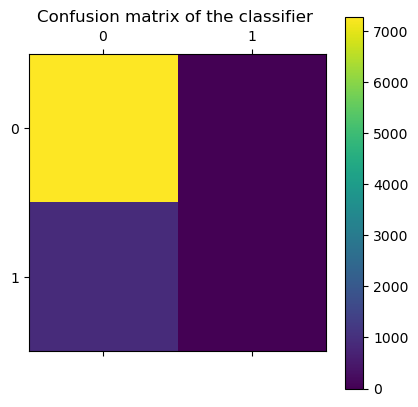

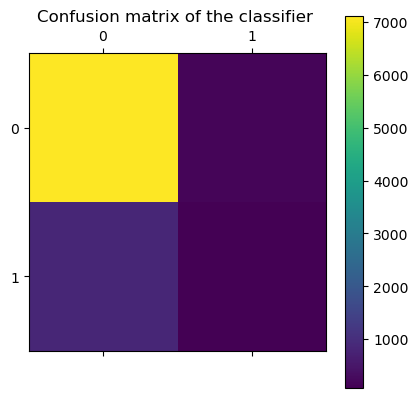

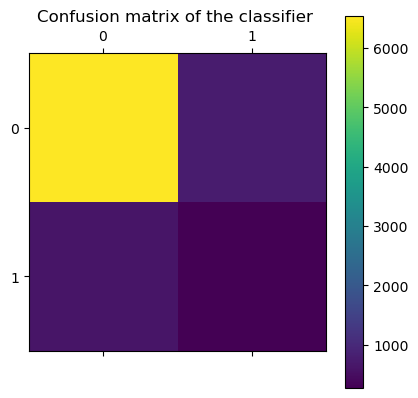

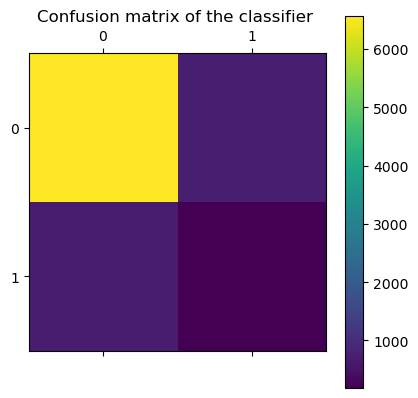

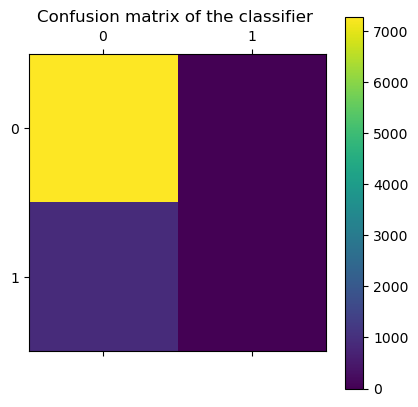

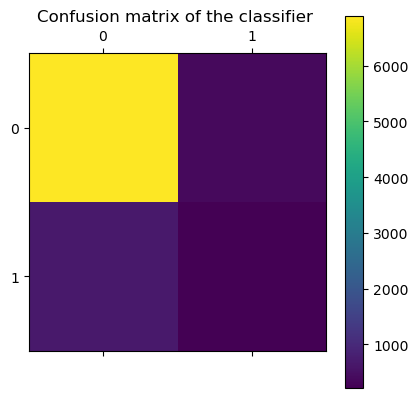

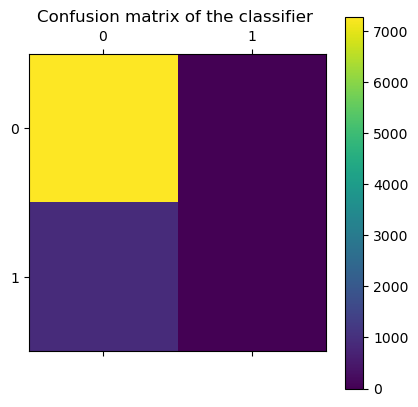

In [54]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix
import pylab as pl

print(confusion_matrix(Y_test, predictionsLR),'LR')
print(confusion_matrix(Y_test, predictionsKNN),"KNN")
print(confusion_matrix(Y_test, predictionsCART),'CART')
print(confusion_matrix(Y_test, predictionsNB),'NB')
print(confusion_matrix(Y_test, predictionsMLP),'MLP')
print(confusion_matrix(Y_test, predictionsRFC),'RFC')
print(confusion_matrix(Y_test, predictionsSVM),'SVM')
cmLR = confusion_matrix(Y_test, predictionsLR)
cmKNN = confusion_matrix(Y_test, predictionsKNN)
cmCART = confusion_matrix(Y_test, predictionsCART)
cmNB = confusion_matrix(Y_test, predictionsNB)
cmMLP = confusion_matrix(Y_test, predictionsMLP)
cmRFC = confusion_matrix(Y_test, predictionsRFC)
cmSVM = confusion_matrix(Y_test, predictionsSVM)
cm=[cmLR,cmKNN,cmCART,cmNB,cmMLP,cmRFC,cmSVM]
for confusions in cm :
    plt.matshow(confusions)
    pl.title(f"Confusion matrix of the classifier ")
    pl.colorbar()
    pl.show()

In [55]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictionsLR),"LR")
print(classification_report(Y_test, predictionsKNN),"KNN")
print(classification_report(Y_test, predictionsCART),"CART")
print(classification_report(Y_test, predictionsNB),"NB")
print(classification_report(Y_test, predictionsMLP),"MLP")
print(classification_report(Y_test, predictionsRFC),"RFC")
print(classification_report(Y_test, predictionsSVM),"SVM")


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      7278
           1       0.00      0.00      0.00       891

    accuracy                           0.89      8169
   macro avg       0.45      0.50      0.47      8169
weighted avg       0.79      0.89      0.84      8169
 LR
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7278
           1       0.31      0.08      0.13       891

    accuracy                           0.88      8169
   macro avg       0.60      0.53      0.53      8169
weighted avg       0.83      0.88      0.85      8169
 KNN
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      7278
           1       0.27      0.30      0.28       891

    accuracy                           0.83      8169
   macro avg       0.59      0.60      0.59      8169
weighted avg       0.84      0.83      0.84      8169
 CART
       

# Part 6. Machine Learning: Regression

## Prepare Data for Regression

In [56]:
dataset4 = dataset2.drop(['response_binary'],axis = 1)
dataset4['duration'] = dataset['duration']

### 6.1 Feature selection

In [57]:
array = dataset4.values
X = array[:,0:20]
Y = array[:,20]

### 6.2 Train/ test split

In [58]:
test_size= 0.20
seed = 10
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

## Compare regression algorithms

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [65]:
modelsR = []
modelsR.append(('LR', LinearRegression()))
modelsR.append(('LASSO', Lasso()))
modelsR.append(('RIDGE', Ridge()))
modelsR.append(('EN', ElasticNet()))
modelsR.append(('KNN', KNeighborsRegressor()))
modelsR.append(('CART', DecisionTreeRegressor()))
modelsR.append(("SVR",SVR()))
modelsR.append(("MLP",MLPRegressor()))

modelsR

In [66]:
modelsR

[('LR', LinearRegression()),
 ('LASSO', Lasso()),
 ('RIDGE', Ridge()),
 ('EN', ElasticNet()),
 ('KNN', KNeighborsRegressor()),
 ('CART', DecisionTreeRegressor()),
 ('SVR', SVR()),
 ('MLP', MLPRegressor())]

In [68]:
results_e2 = []
names_e2 = []

for name, model in modelsR:
    # define how to split off validation data
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2.append(cv_results)
    names_e2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -18.662793 (1.701893)
LASSO: -18.700153 (1.689395)
RIDGE: -18.662773 (1.701885)
EN: -18.699523 (1.689535)
KNN: -22.086144 (1.658231)
CART: -37.588093 (2.179532)
SVR: -20.412548 (1.871432)
MLP: -27.046121 (11.028902)


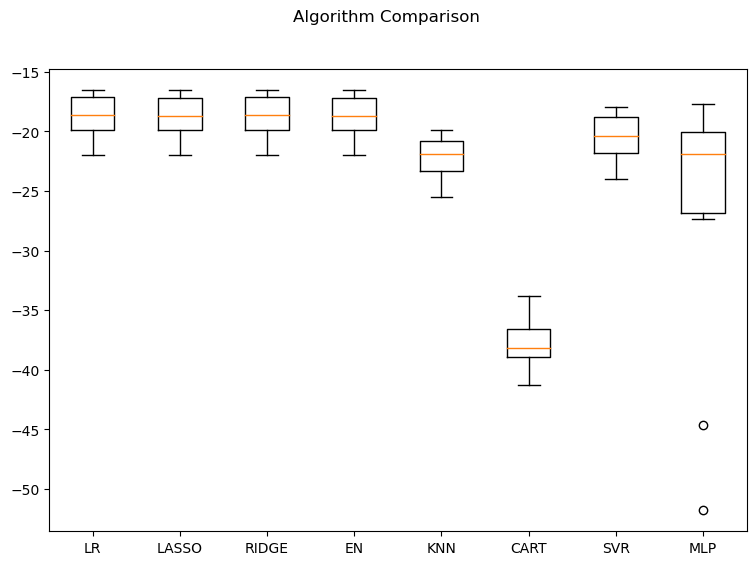

In [69]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2)
plt.show()

**Ridge regression slightly outperforms other models.**

## Stardardize Data

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))

In [71]:
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledMLP', Pipeline([('Scaler', StandardScaler()),('MLP', MLPRegressor())])))

In [72]:
pipelines

[('ScaledLR',
  Pipeline(steps=[('Scaler', StandardScaler()), ('LR', LinearRegression())])),
 ('ScaledLASSO',
  Pipeline(steps=[('Scaler', StandardScaler()), ('LASSO', Lasso())])),
 ('ScaledRIDGE',
  Pipeline(steps=[('Scaler', StandardScaler()), ('RIDGE', Ridge())])),
 ('ScaledEN',
  Pipeline(steps=[('Scaler', StandardScaler()), ('EN', ElasticNet())])),
 ('ScaledKNN',
  Pipeline(steps=[('Scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])),
 ('ScaledCART',
  Pipeline(steps=[('Scaler', StandardScaler()),
                  ('CART', DecisionTreeRegressor())])),
 ('ScaledSVR', Pipeline(steps=[('Scaler', StandardScaler()), ('SVR', SVR())])),
 ('ScaledMLP',
  Pipeline(steps=[('Scaler', StandardScaler()), ('MLP', MLPRegressor())]))]

In [75]:
results_e2_normalized = []
names_e2_normalized = []

for name, model in pipelines:
    # define how to split off validation data
    kfold = KFold(n_splits=10, random_state=seed , shuffle = True)
    
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2_normalized.append(cv_results)
    names_e2_normalized.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -18.662946 (1.700860)
ScaledLASSO: -18.721203 (1.686904)
ScaledRIDGE: -18.662793 (1.701892)
ScaledEN: -18.721203 (1.686904)
ScaledKNN: -22.146727 (1.766415)
ScaledCART: -37.602827 (2.492108)
ScaledSVR: -20.316773 (1.889492)
ScaledMLP: -18.767210 (1.706821)


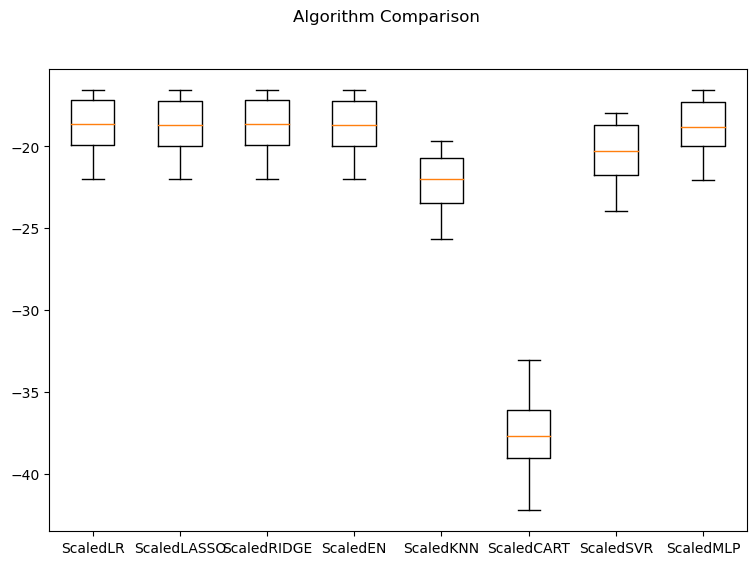

In [76]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2_normalized)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2_normalized)
plt.show()

**After standardization, ridge regression is still the best-performing model.**

## Test models on the test set

In [77]:
ridge = Ridge()
LRR = LinearRegression()
lasso = Lasso()
EN = ElasticNet()
KNNR = KNeighborsRegressor()
CARTR= DecisionTreeRegressor()
SVR = SVR()
MLPR = MLPRegressor()
modelR =[ridge,LRR,lasso,EN,KNNR,CARTR,SVR,MLPR]
predictR=[]
for model in modelR :
    model.fit(X_train,Y_train)
    predictR.append(model.predict(X_test))


In [78]:
modelPredict = list(zip(modelR,predictR))
modelPredict

[(Ridge(),
  array([4.47589141, 4.02728182, 3.64118832, ..., 4.41214513, 4.22515092,
         4.36199455])),
 (LinearRegression(),
  array([4.47595098, 4.02726526, 3.64094472, ..., 4.4121673 , 4.22505816,
         4.36200857])),
 (Lasso(),
  array([4.27096781, 4.16897071, 4.28506008, ..., 4.24699376, 4.413695  ,
         4.31436169])),
 (ElasticNet(),
  array([4.27732543, 4.16351906, 4.26179098, ..., 4.23880223, 4.39418208,
         4.31880064])),
 (KNeighborsRegressor(),
  array([3.212, 3.308, 2.878, ..., 3.884, 2.416, 3.554])),
 (DecisionTreeRegressor(), array([0.43, 1.08, 1.78, ..., 5.17, 0.68, 2.28])),
 (SVR(),
  array([3.04899236, 2.85689932, 3.00159612, ..., 2.93613087, 3.04412286,
         3.1104095 ])),
 (MLPRegressor(),
  array([4.31560126, 7.80392207, 3.79548257, ..., 4.62491843, 3.78091307,
         4.0264382 ]))]

In [79]:
predictR

[array([4.47589141, 4.02728182, 3.64118832, ..., 4.41214513, 4.22515092,
        4.36199455]),
 array([4.47595098, 4.02726526, 3.64094472, ..., 4.4121673 , 4.22505816,
        4.36200857]),
 array([4.27096781, 4.16897071, 4.28506008, ..., 4.24699376, 4.413695  ,
        4.31436169]),
 array([4.27732543, 4.16351906, 4.26179098, ..., 4.23880223, 4.39418208,
        4.31880064]),
 array([3.212, 3.308, 2.878, ..., 3.884, 2.416, 3.554]),
 array([0.43, 1.08, 1.78, ..., 5.17, 0.68, 2.28]),
 array([3.04899236, 2.85689932, 3.00159612, ..., 2.93613087, 3.04412286,
        3.1104095 ]),
 array([4.31560126, 7.80392207, 3.79548257, ..., 4.62491843, 3.78091307,
        4.0264382 ])]

## Evaluate For Models

In [80]:
from sklearn.metrics import mean_squared_error
for model , predict in modelPredict :
    print(f"the MSE for {model} is ", mean_squared_error(Y_test,predict) )


the MSE for Ridge() is  17.7797404329447
the MSE for LinearRegression() is  17.779759459813064
the MSE for Lasso() is  17.789446492753278
the MSE for ElasticNet() is  17.78963050598387
the MSE for KNeighborsRegressor() is  21.15410388444118
the MSE for DecisionTreeRegressor() is  35.86978241725637
the MSE for SVR() is  19.391274012674103
the MSE for MLPRegressor() is  19.203221247909198


In [83]:
from sklearn.metrics import mean_absolute_percentage_error
for model , predict in modelPredict :
    print(f'The MAPE for {model} is' , mean_absolute_percentage_error(Y_test, predict))

The MAPE for Ridge() is 1.6946465990313775
The MAPE for LinearRegression() is 1.6946463199356296
The MAPE for Lasso() is 1.6968983560575415
The MAPE for ElasticNet() is 1.6968553253997536
The MAPE for KNeighborsRegressor() is 1.7224085290922722
The MAPE for DecisionTreeRegressor() is 1.9502411807102373
The MAPE for SVR() is 1.1313575105887166
The MAPE for MLPRegressor() is 1.5855391634614244
